In [1]:
import torch
from torch import nn
import numpy as np

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


Text(0, 0.5, 'color_intensity')

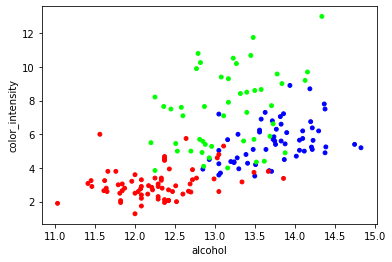

In [3]:
from sklearn import datasets
import matplotlib.pyplot as plt

wine     = datasets.load_wine()
features = [0, 9]
data     = wine.data[:, features]
targets  = wine.target

xlabel_str = wine.feature_names[features[0]]
ylabel_str = wine.feature_names[features[1]]
title_str  = '2D Wine classifier'

plt.scatter(data[:,0], data[:,1], c=targets, s=15, cmap=plt.cm.brg)
plt.xlabel(xlabel_str)
plt.ylabel(ylabel_str)

Text(0, 0.5, 'color_intensity')

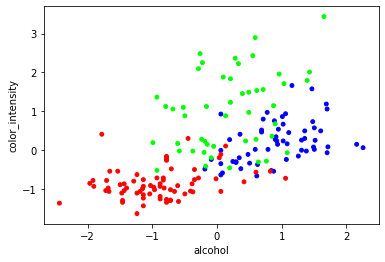

In [4]:
# Esta célula realiza um tipo de normalização nos intervalos dos dados
# Como pode-se ver abaixo, as duas dimensões agora estão em intervalos mais semelhantes
# ! COMENTAR ESTA CÉLULA CAUSA DIFICULDADE PARA O MODELO CONVERGIR !
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data   = scaler.fit_transform(data)

xlabel_str = wine.feature_names[features[0]]
ylabel_str = wine.feature_names[features[1]]
title_str  = '2D Wine classifier'

plt.scatter(data[:,0], data[:,1], c=targets, s=15, cmap=plt.cm.brg)
plt.xlabel(xlabel_str)
plt.ylabel(ylabel_str)

In [5]:
in_size  = data.shape[1]
hid_size = 32
out_size = len(wine.target_names)

In [6]:
torch.manual_seed(42)

In [7]:
net = nn.Sequential(
    nn.Linear(in_size, hid_size),
    nn.ReLU(),
    nn.Linear(hid_size, out_size),
    nn.Softmax()
).to(device)

print(net)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=3, bias=True)
  (3): Softmax(dim=None)
)


In [8]:
# Função para a fronteira de decisão

def plot_boundary(X, y, model,flag=1):
  x_min, x_max = X[:,0].min()-0.1, X[:, 0].max()+0.1
  y_min, y_max = X[:,1].min()-0.1, X[:, 1].max()+0.1

  spacing = min(x_max - x_min, y_max - y_min) / 100

  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))
  
  data = np.hstack((XX.ravel().reshape(-1,1),
                    YY.ravel().reshape(-1,1)))
  
  # For binary problems (flag=0)
  if flag == 0:
    db_prob = model(Variable(torch.Tensor(data)).cuda()) # Variable is deprecated
    clf = np.where(db_prob.cpu().data < 0.5, 0, 1)
  
  # For multi-class problems (flag=1)
  elif flag == 1:
    db_prob = model(torch.Tensor(data).to(device))
    clf = np.argmax(db_prob.cpu().data.numpy(), axis=-1)

  Z = clf.reshape(XX.shape)

  plt.contourf(XX, YY, Z, cmap=plt.cm.brg, alpha=0.5)
  plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', s=55, cmap=plt.cm.brg)

C:\Users\Claudio\anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


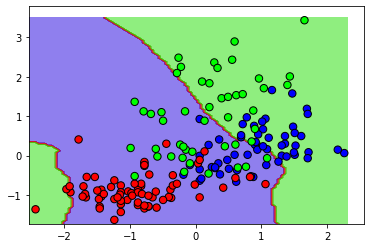

In [9]:
plot_boundary(data, targets, net, 1)

In [10]:
# Cria os tensores dos dados e rótulos e faz o cast na GPU

Xtns = torch.FloatTensor(data).to(device)
Ytns = torch.LongTensor(targets).to(device)

In [11]:
from torch import optim
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador: Gradiente descendente
# optimizer = optim.SGD(net.parameters(), lr=1e-3)
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, nesterov=True)
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adagrad(net.parameters(), lr=1e-3, weight_decay=5e-4)
# optimizer = optim.Adadelta(net.parameters(), lr=1e-3, weight_decay=5e-4)
# optimizer = optim.RMSprop(net.parameters(), lr=1e-3, weight_decay=5e-4, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)

C:\Users\Claudio\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


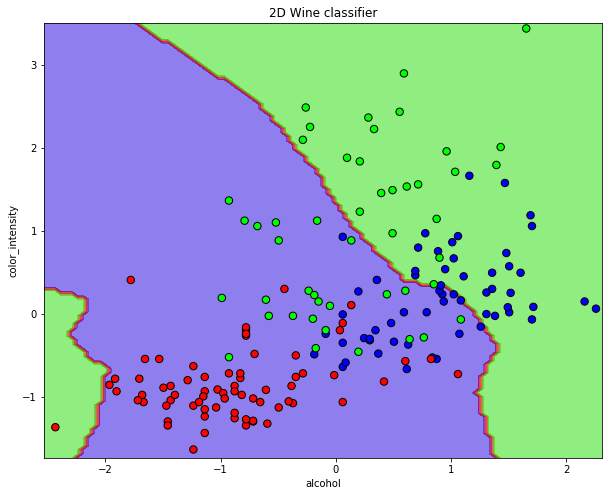

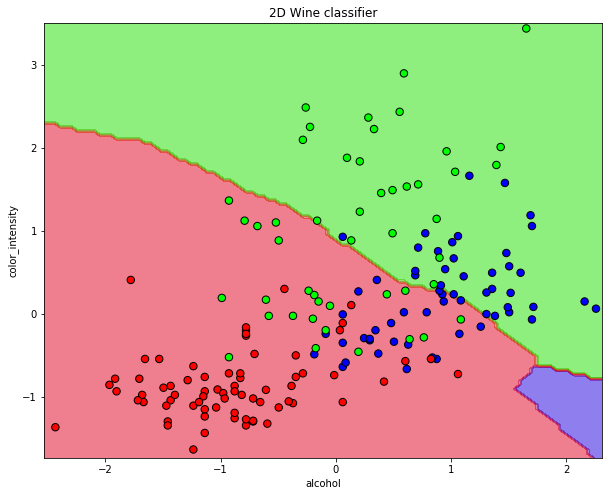

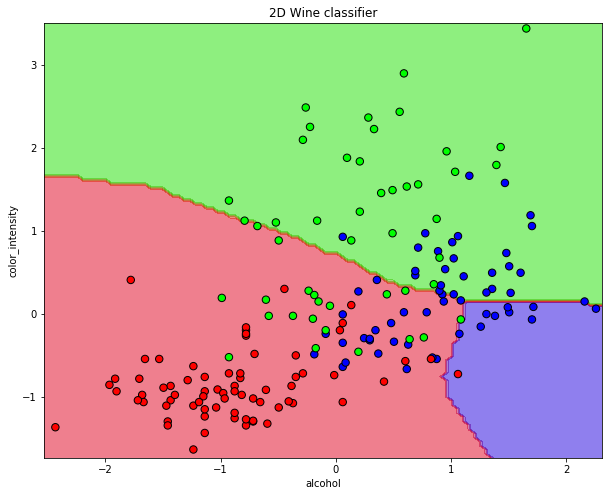

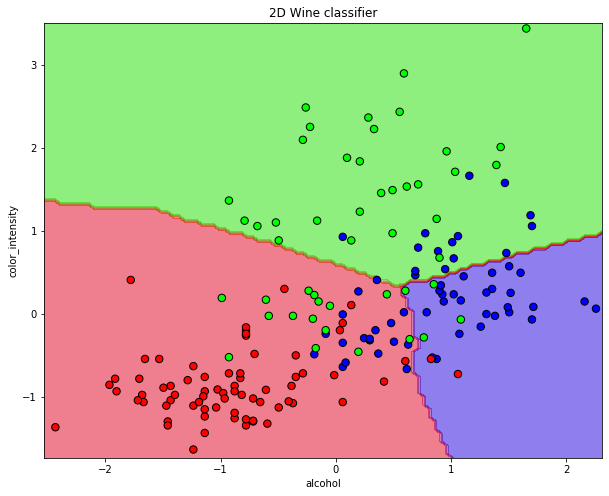

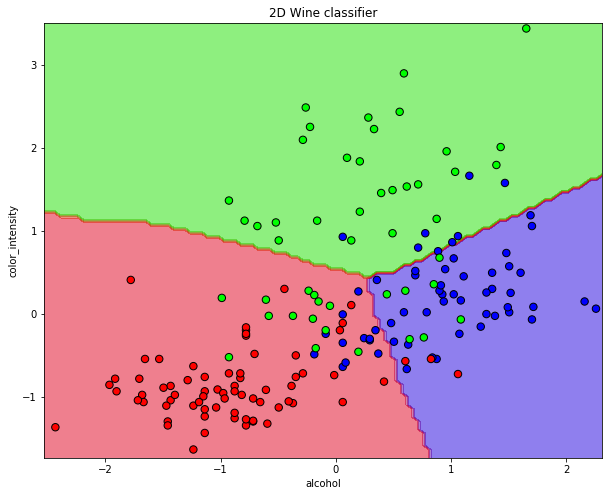

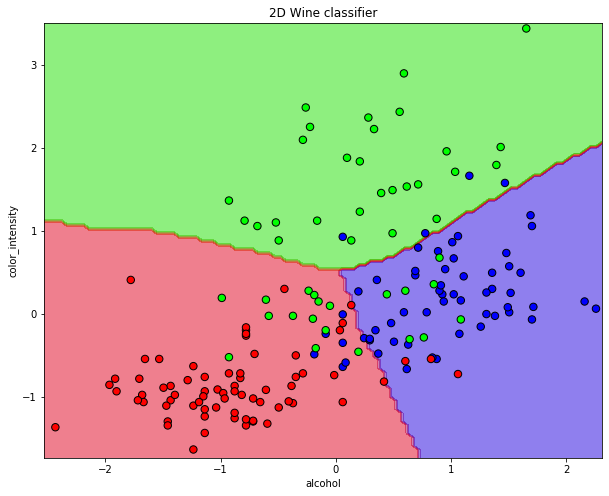

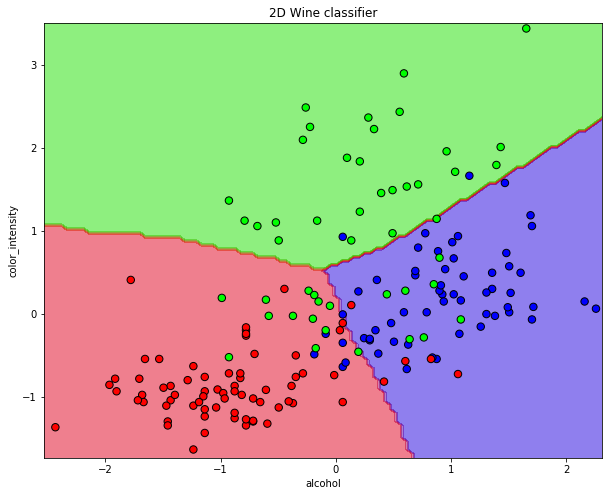

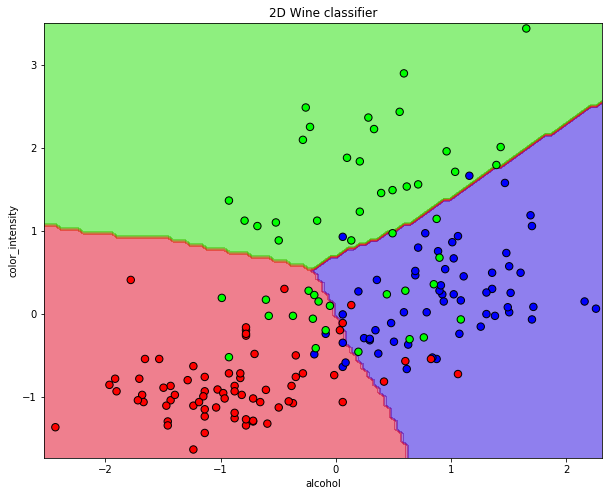

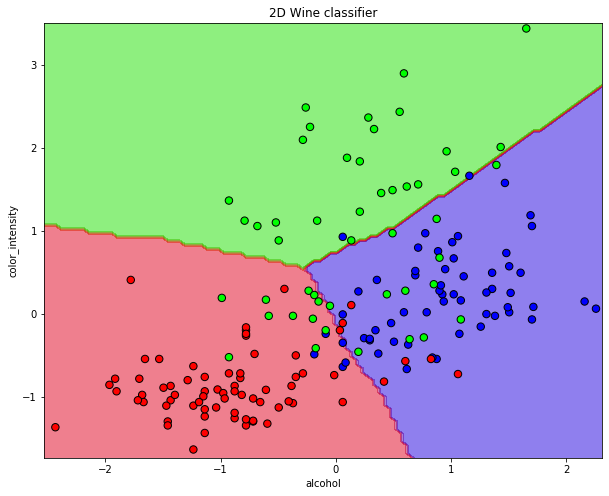

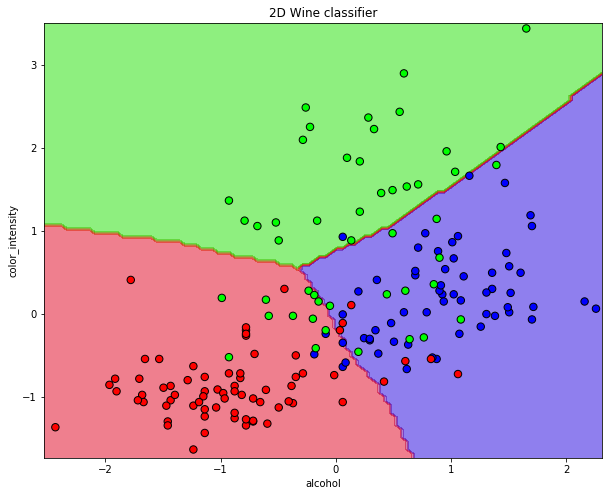

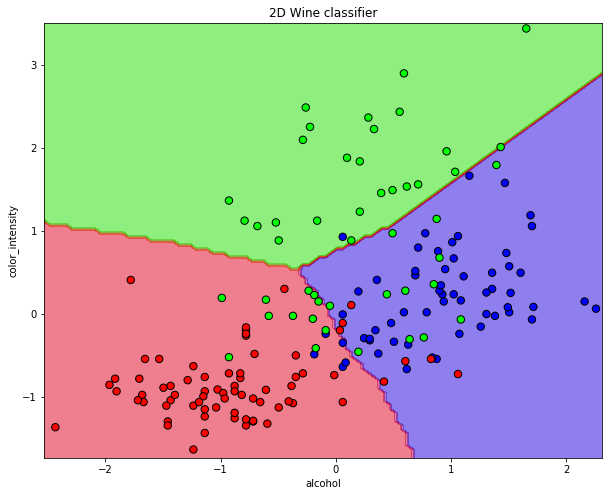

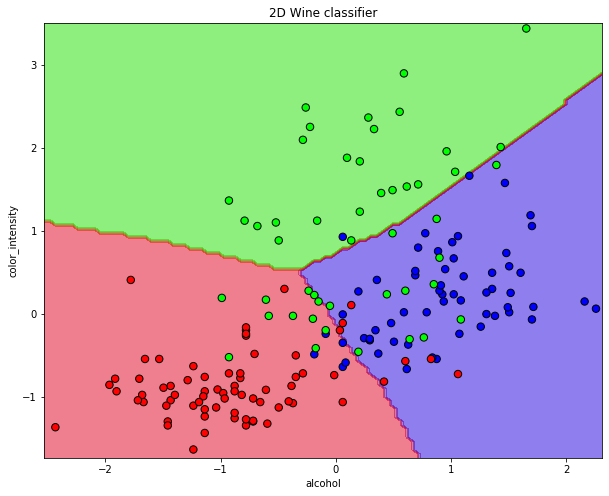

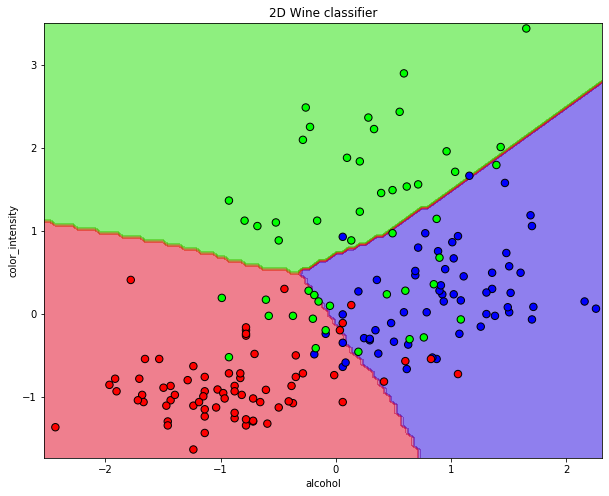

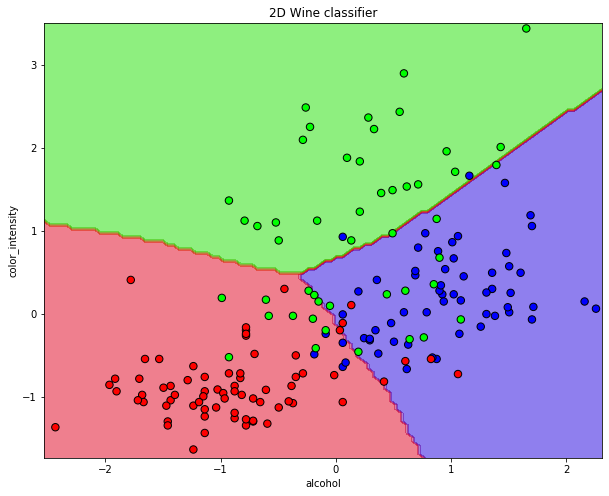

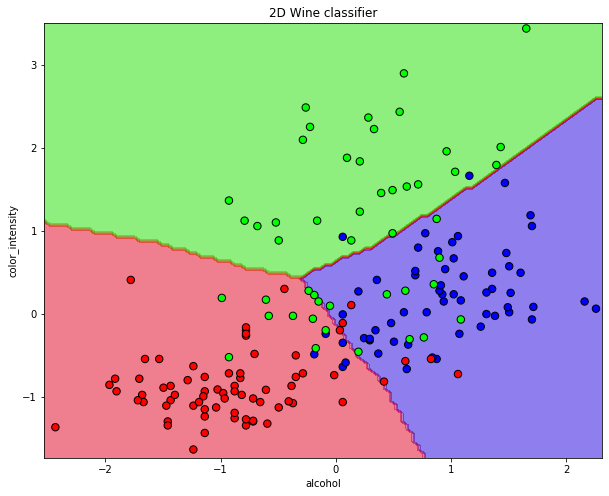

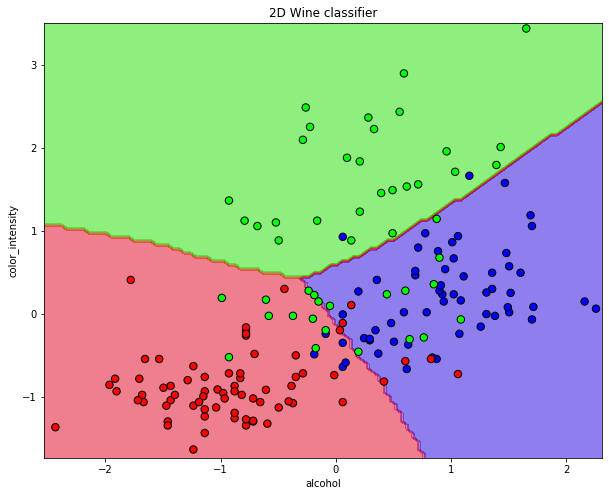

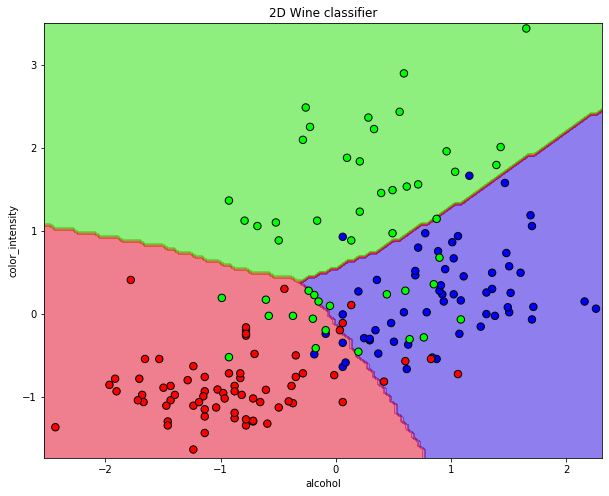

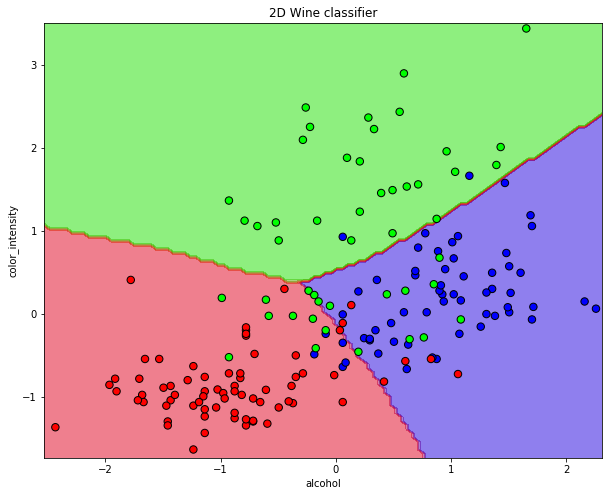

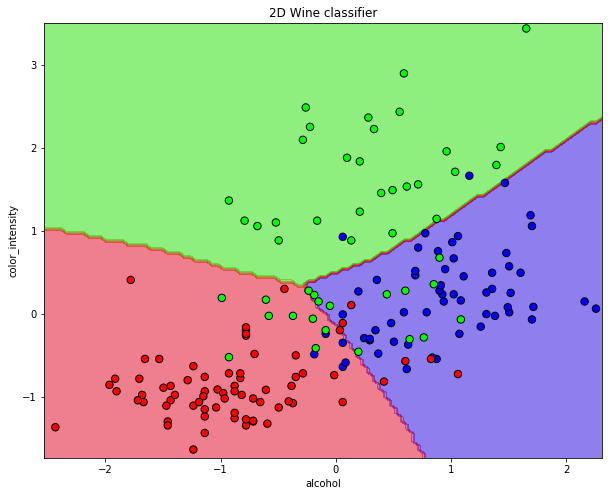

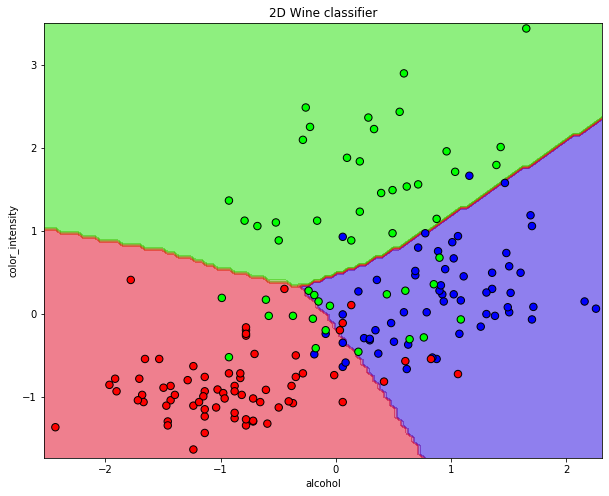

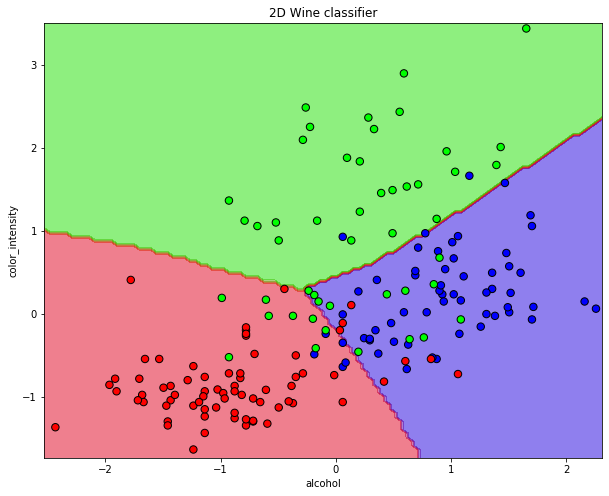

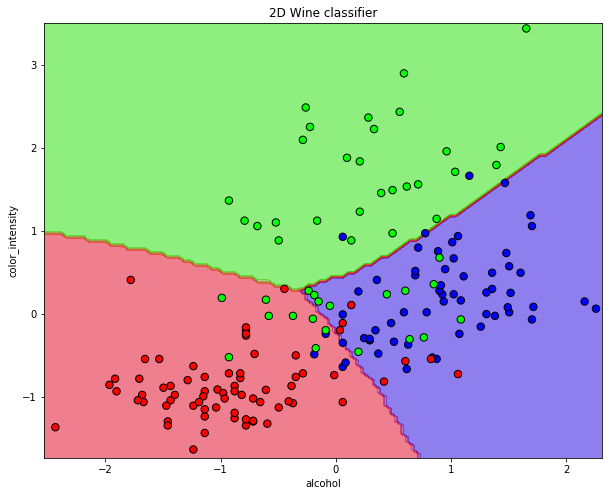

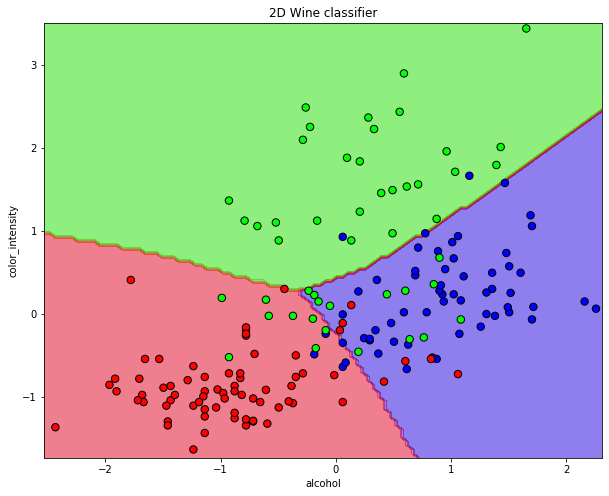

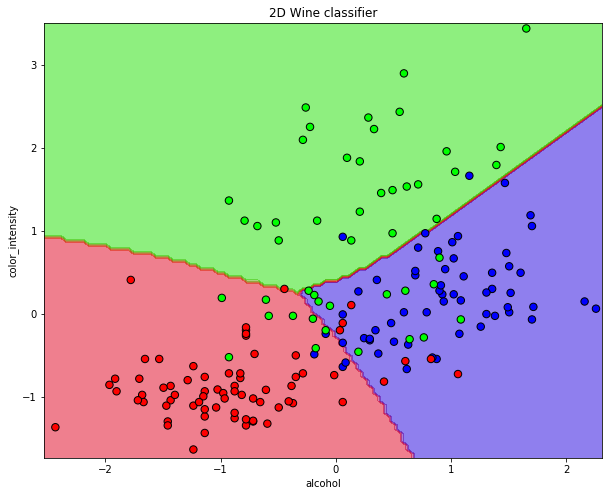

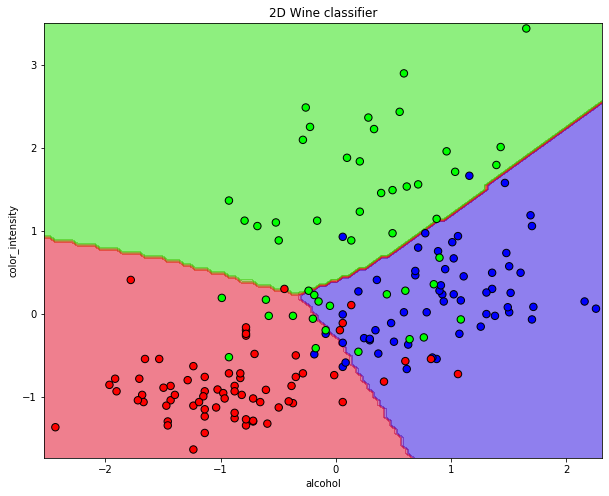

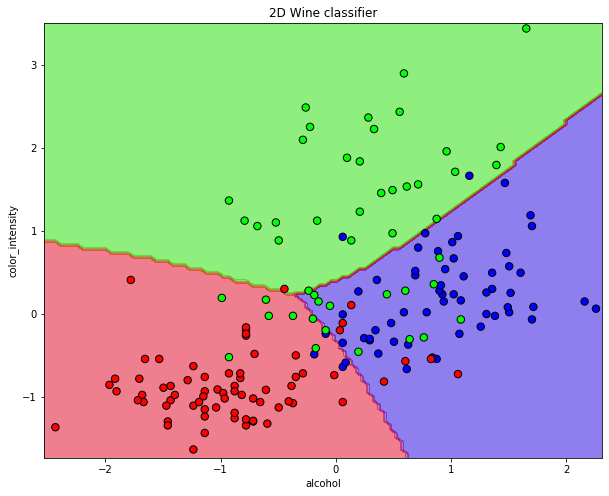

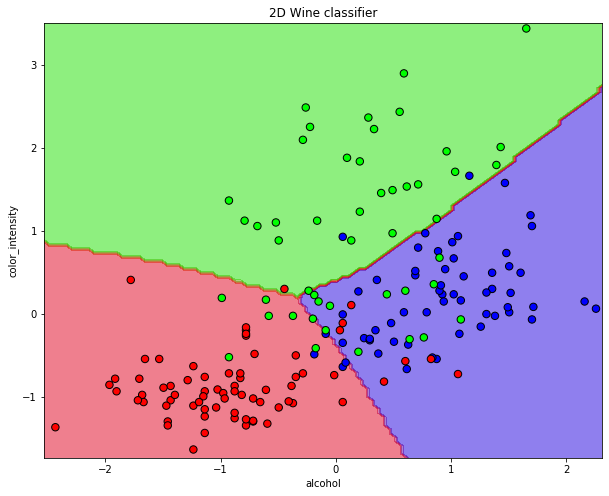

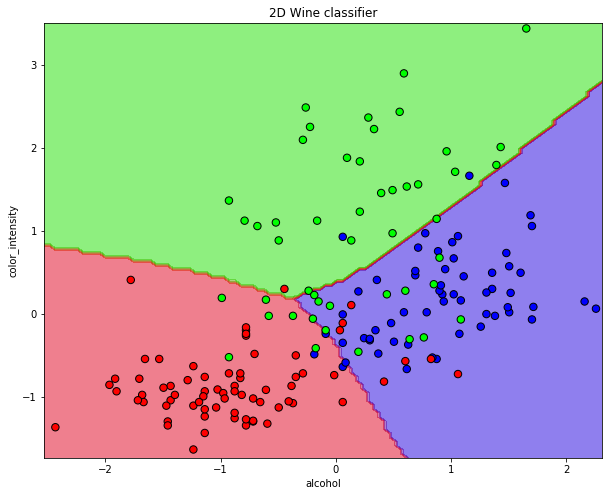

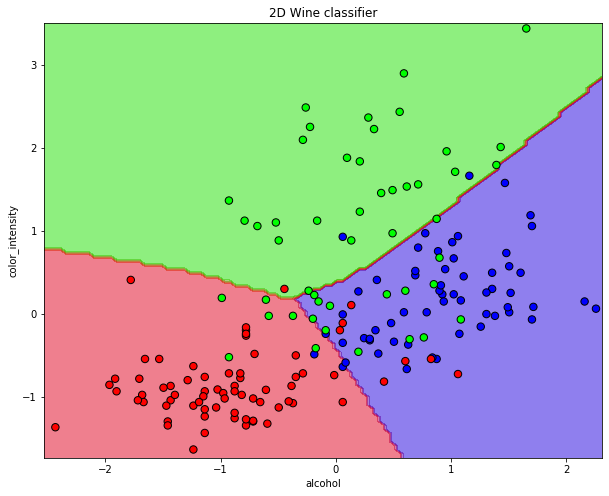

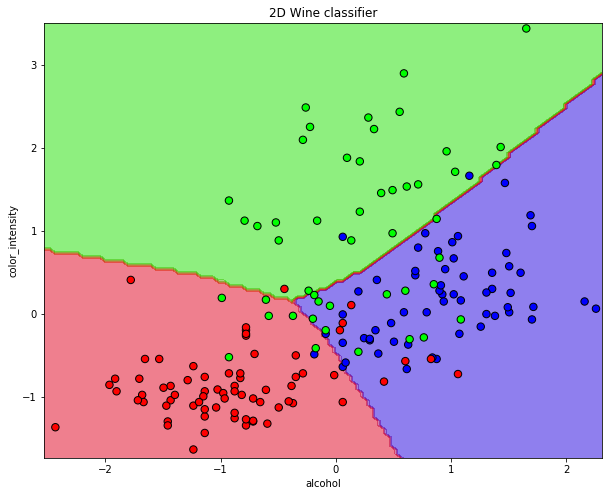

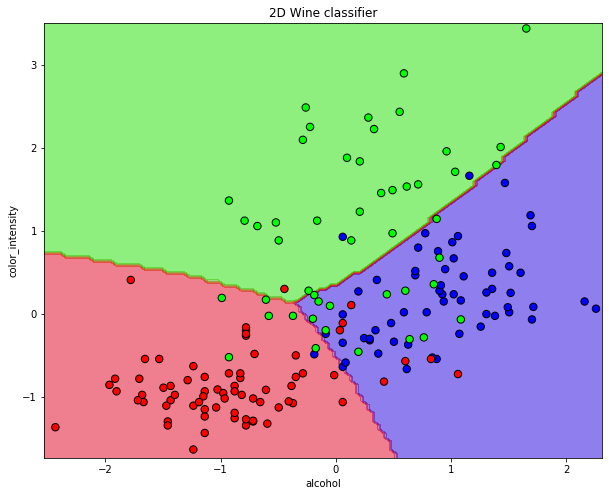

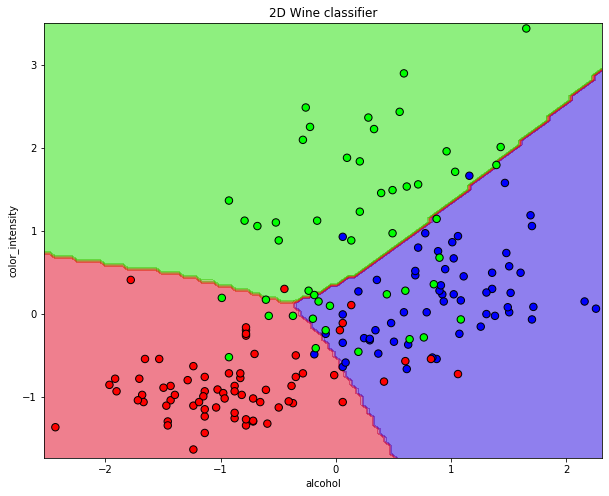

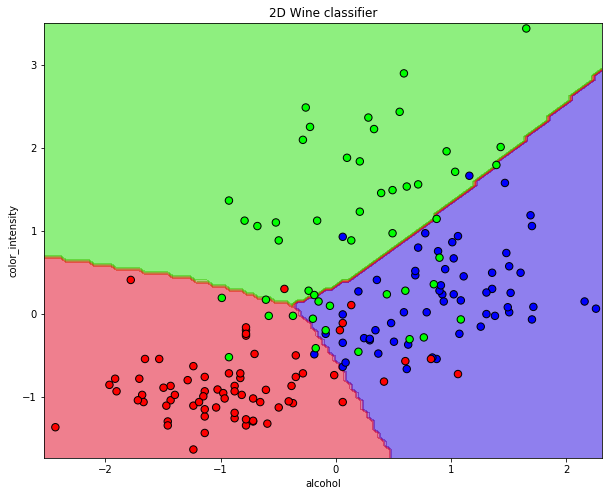

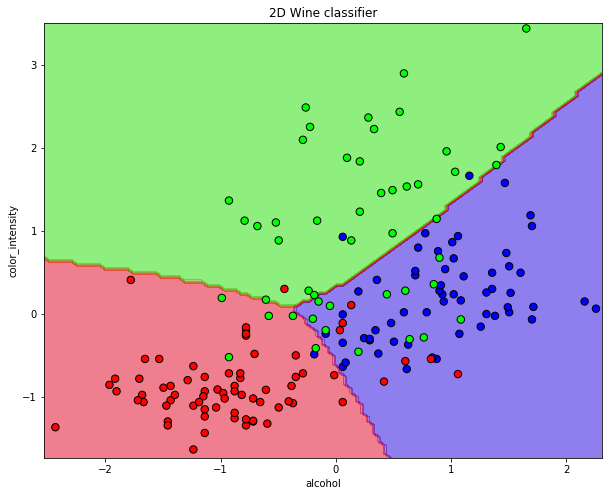

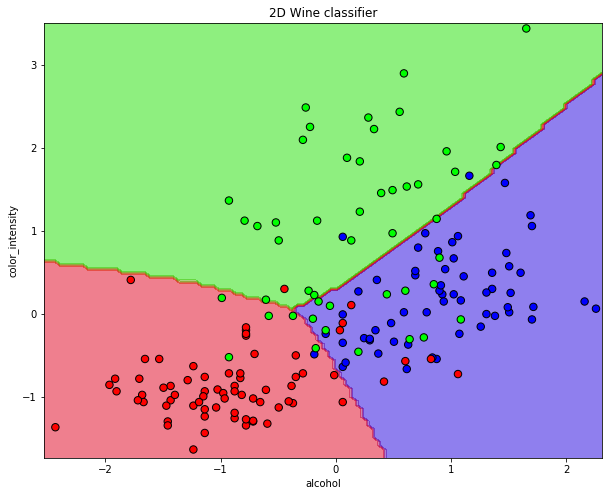

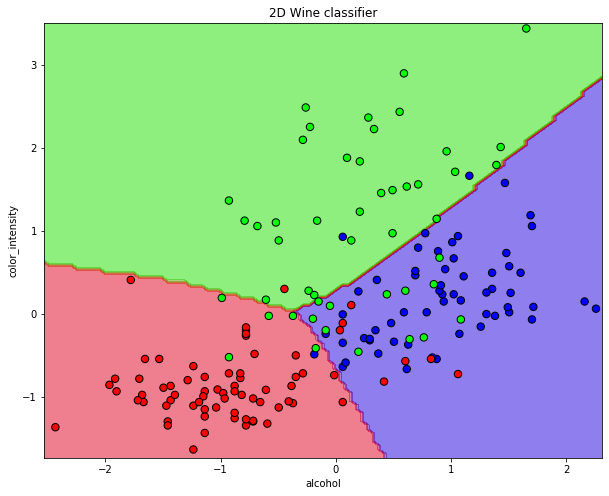

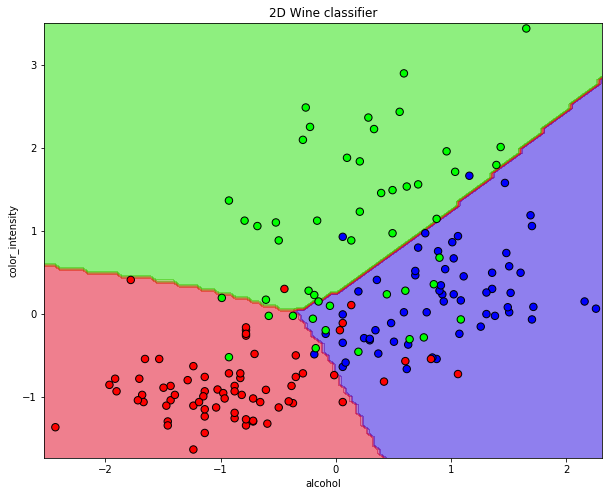

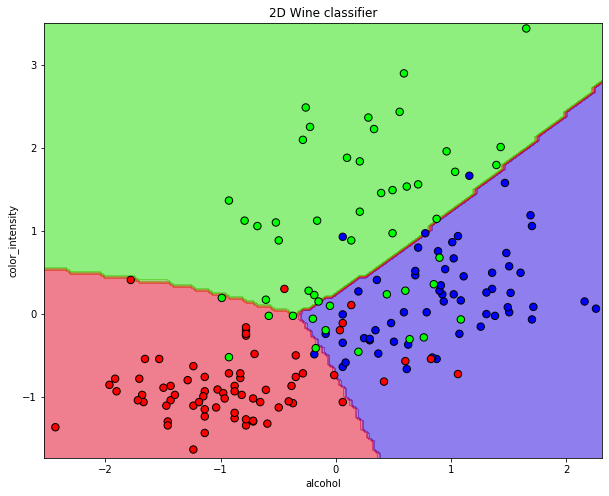

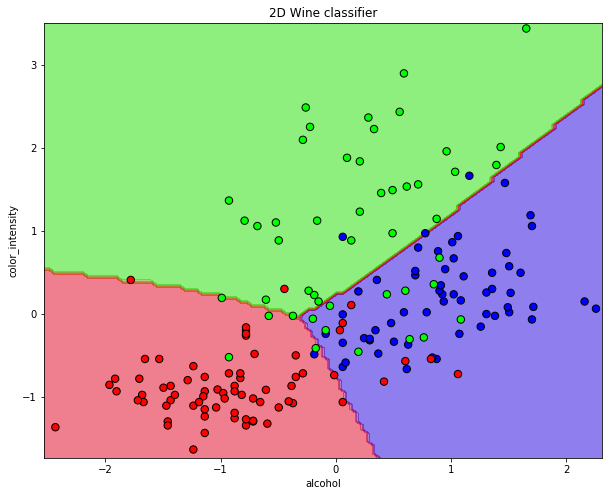

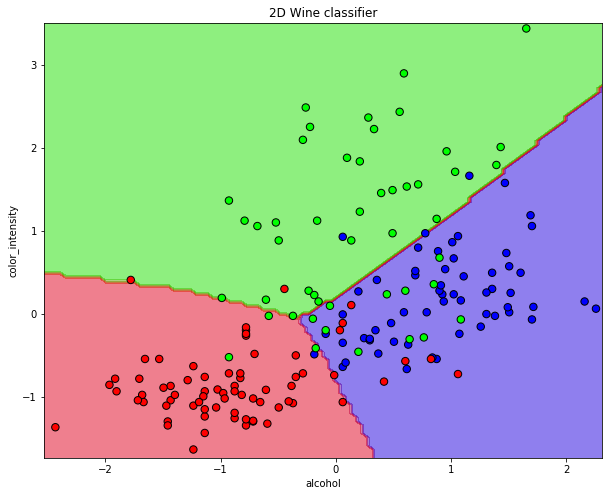

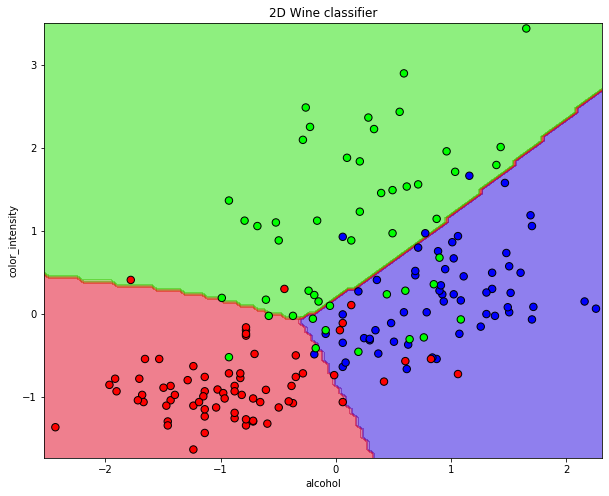

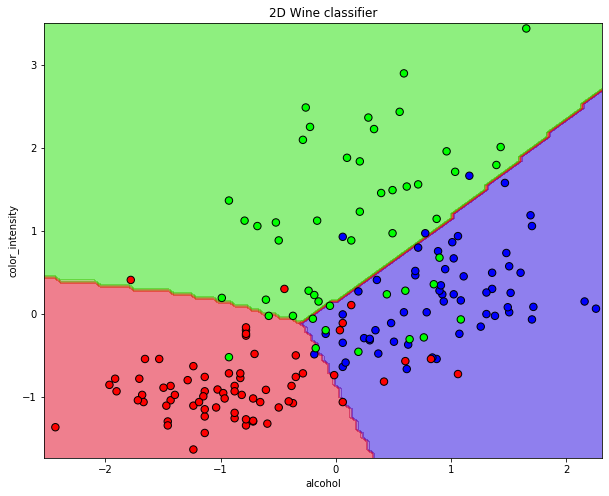

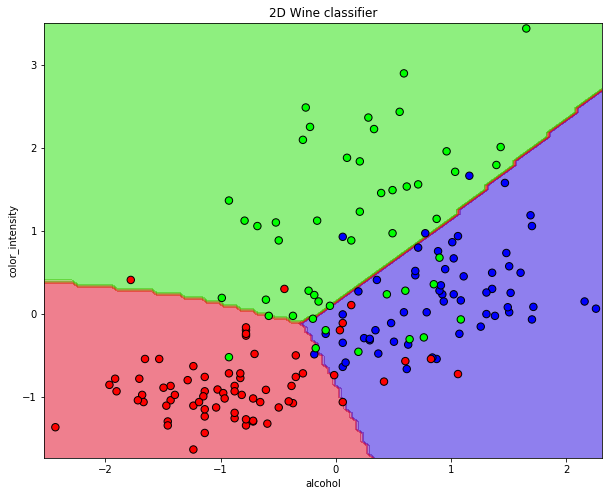

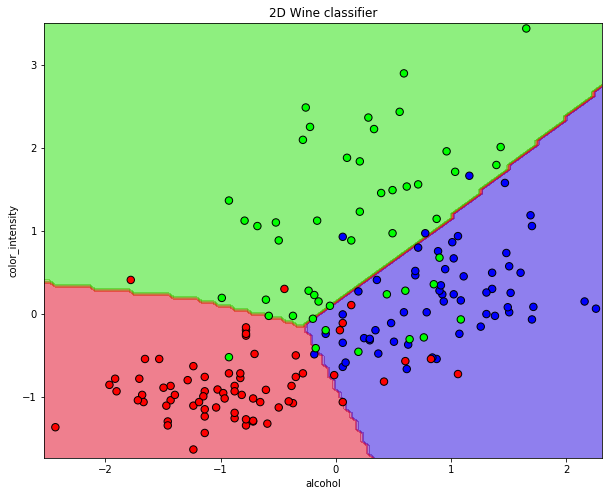

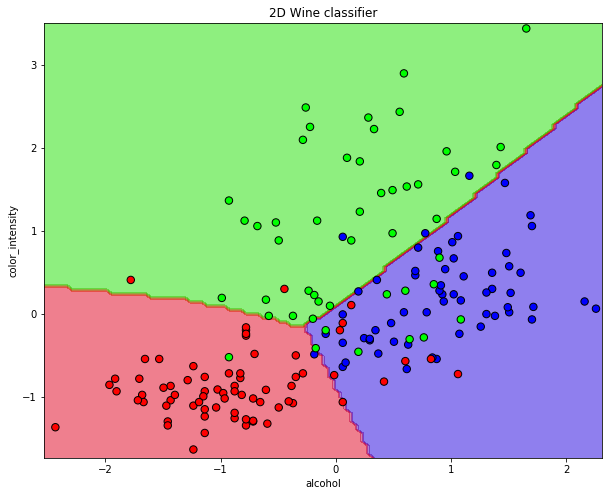

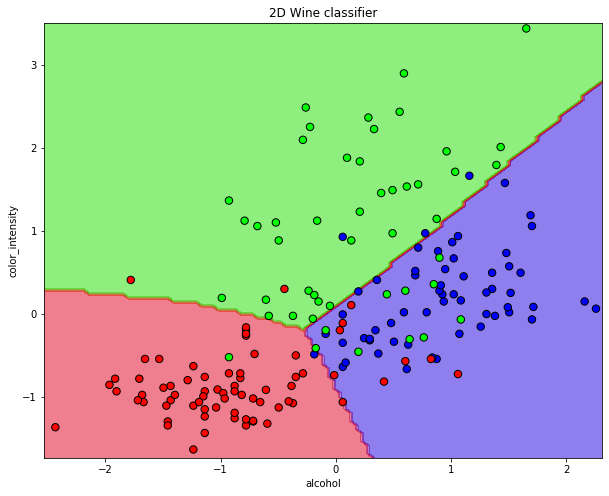

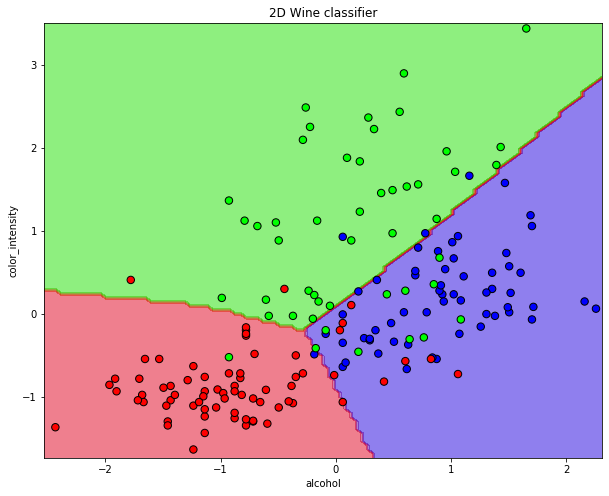

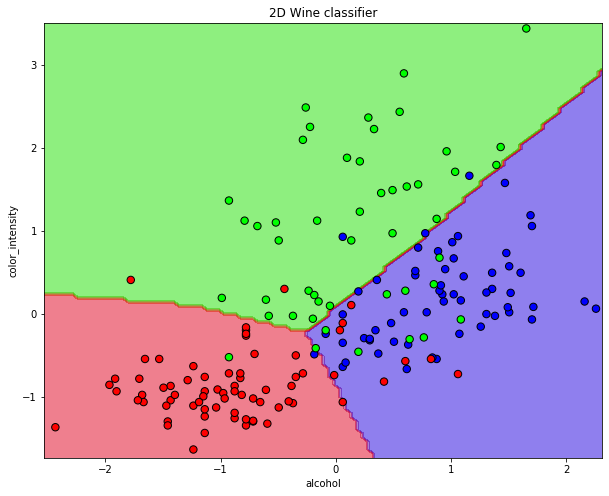

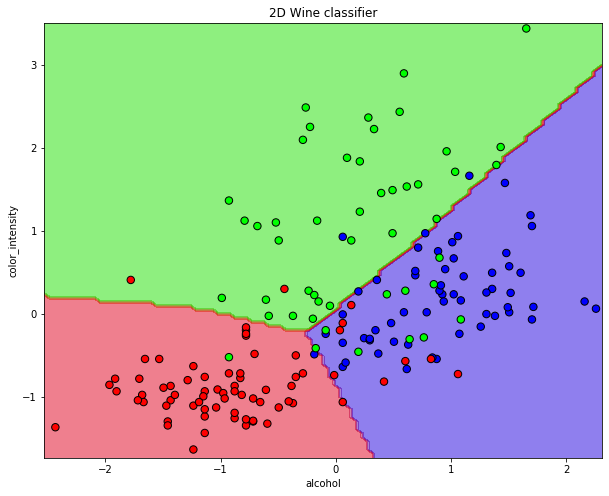

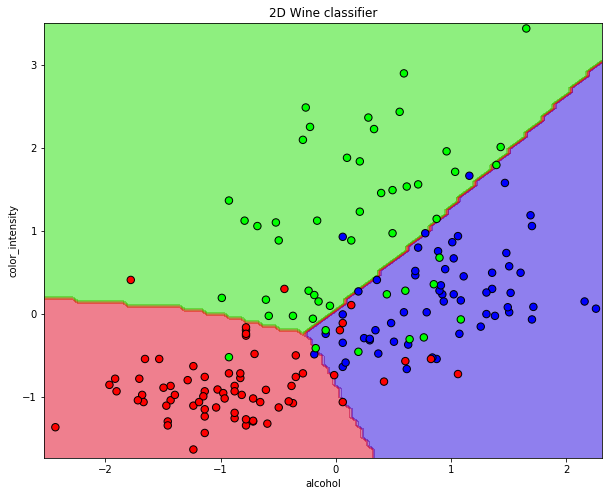

In [12]:
for i in range(500):
  # Forward
  pred = net(Xtns)
  loss = criterion(pred, Ytns)

  # Backward
  loss.backward()
  optimizer.step()

  if i % 10 == 0:
    fig = plt.figure(figsize=(10,8))
#     fig = plt.figure()
    plot_boundary(data, targets, net)
    plt.xlabel(xlabel_str)
    plt.ylabel(ylabel_str)
    plt.title(title_str)
    plt.savefig('.\\out\\adam_{:03d}.png'.format(i))